![](https://web.archive.org/web/20161019192412im_/http://lisp.vse.cz/pkdd99/data.gif)

[Guide to the Financial Data Set](https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm)
    
[1999 Czech Financial Dataset - Real Anonymized Transactions](https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions)

In [1]:
import pandas as pd
import numpy as np
import glob
import time

import regex as re

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import scatter_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.utils import resample

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  #GBM algorithm
from xgboost import XGBClassifier

import statsmodels.api as sm

In [2]:
files = sorted(glob.glob('*.csv')) # look at all csv's in the directory
files

['account.csv',
 'card.csv',
 'client.csv',
 'disp.csv',
 'district.csv',
 'loan.csv',
 'order.csv',
 'trans.csv']

In [3]:
# create a dataframe using csv's in above list files
print("The dataframes created from csv's are:\n")
for f in files:
    vars()[f.split('.')[0]] = pd.read_csv(f, delimiter = ';')
    print("Shape of **", f.split('.')[0], "** dataframe is: ", vars()[f.split('.')[0]].shape)

The dataframes created from csv's are:

Shape of ** account ** dataframe is:  (4500, 4)
Shape of ** card ** dataframe is:  (892, 4)
Shape of ** client ** dataframe is:  (5369, 3)
Shape of ** disp ** dataframe is:  (5369, 4)
Shape of ** district ** dataframe is:  (77, 16)
Shape of ** loan ** dataframe is:  (682, 7)
Shape of ** order ** dataframe is:  (6471, 6)
Shape of ** trans ** dataframe is:  (1056320, 10)


In [4]:
account.head()

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101
2,704,55,POPLATEK MESICNE,930101
3,2378,16,POPLATEK MESICNE,930101
4,2632,24,POPLATEK MESICNE,930102


In [5]:
card.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00
3,70,439,classic,940208 00:00:00
4,577,3687,classic,940215 00:00:00


In [6]:
client.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [7]:
disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [8]:
# rename the columns for district

district.columns = ["district code", "district name", "region", "no. of inhabitants", 
                    "no. of municipalities with inhabitants < 499", 
                    "no. of municipalities with inhabitants 500-1999", 
                    "no. of municipalities with inhabitants 2000-9999",
                    "no. of municipalities with inhabitants >10000", 
                    "no. of cities", "ratio of urban inhabitants" , "average salary",
                    "unemploymant rate 95", "unemploymant rate 96", 
                    "no. of enterpreneurs per 1000 inhabitants", "no. of commited crimes 95",
                    "no. of commited crimes 96"]

district.head()

,district code,district name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate 95,unemploymant rate 96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes 95,no. of commited crimes 96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [9]:
district['district code'] = district['district code'].astype(int)

In [10]:
loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A


In [11]:
order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,


In [12]:
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


In [13]:
# merge dataframes by same keys or column names

In [14]:
df1 = pd.merge(account, loan, left_on='account_id', right_on='account_id', how='inner')
df2 = pd.merge(account, order, left_on='account_id', right_on='account_id', how='inner')
df3 = pd.merge(account, trans, left_on='account_id', right_on='account_id', how='inner')
df4 = pd.merge(account, district, left_on='district_id', right_on='district code', how='inner')
df5 = pd.merge(account, disp, left_on='account_id', right_on='account_id', how='inner')
df = pd.merge(disp, card, left_on='disp_id', right_on='disp_id', how='inner')
df6 = pd.merge(account, df, left_on='account_id', right_on='account_id', how='inner')
df = pd.merge(disp, client, left_on='client_id', right_on='client_id', how='inner')
df7 = pd.merge(account, df, left_on='account_id', right_on='account_id', how='inner')

In [15]:
from functools import reduce

In [16]:
dfs = [df1, df2, df3, df4, df5, df6, df7]

In [17]:
dataframe = reduce(lambda left,right: pd.merge(left, right, on = "account_id"), dfs)

In [18]:
data = dataframe[['account_id', 'loan_id', 'duration', 'payments', 'status', 'order_id', 'bank_to', 'account_to', 'trans_id', 'operation', 'amount', 'balance', 'bank', 'account', 'district code', 'district name', 'region', 'no. of inhabitants', 'no. of municipalities with inhabitants < 499', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999', 'no. of municipalities with inhabitants >10000', 'no. of cities', 'ratio of urban inhabitants', 'average salary', 'unemploymant rate 95', 'unemploymant rate 96', 'no. of enterpreneurs per 1000 inhabitants', 'no. of commited crimes 95', 'no. of commited crimes 96', 'card_id', 'issued', 'frequency', 'date', 'disp_id', 'client_id', 'type', 'birth_number']]
data.head()

,account_id,loan_id,duration,payments,status,order_id,bank_to,account_to,trans_id,operation,...,no. of commited crimes 95,no. of commited crimes 96,card_id,issued,frequency,date,disp_id,client_id,type,birth_number
0,5891,6202,12,5432.0,A,38118,EF,95617645,1736607,VKLAD,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
1,5891,6202,12,5432.0,A,38118,EF,95617645,1736609,PREVOD Z UCTU,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
2,5891,6202,12,5432.0,A,38118,EF,95617645,1736950,VYBER,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
3,5891,6202,12,5432.0,A,38118,EF,95617645,3673340,NaN,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
4,5891,6202,12,5432.0,A,38118,EF,95617645,1736610,PREVOD Z UCTU,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929


In [19]:
data.shape

(174249, 38)

In [20]:
# let's look at columns with missing values
pd.DataFrame(data.isna().sum())[pd.DataFrame(data.isna().sum())[0] > 0]

,0
operation,24197
bank,120490
account,107567


In [21]:
# Let's drop the columns with missing data

In [22]:
data = data.drop(['operation', 'bank', 'account'], axis = 1)

In [23]:
[str(i) + ' -----> ' + str(data[i].dtype) for i in data]

['account_id -----> int64',
 'loan_id -----> int64',
 'duration -----> int64',
 'payments -----> float64',
 'status -----> object',
 'order_id -----> int64',
 'bank_to -----> object',
 'account_to -----> int64',
 'trans_id -----> int64',
 'amount -----> float64',
 'balance -----> float64',
 'district code -----> int32',
 'district name -----> object',
 'region -----> object',
 'no. of inhabitants -----> int64',
 'no. of municipalities with inhabitants < 499 -----> int64',
 'no. of municipalities with inhabitants 500-1999 -----> int64',
 'no. of municipalities with inhabitants 2000-9999 -----> int64',
 'no. of municipalities with inhabitants >10000 -----> int64',
 'no. of cities -----> int64',
 'ratio of urban inhabitants -----> float64',
 'average salary -----> int64',
 'unemploymant rate 95 -----> object',
 'unemploymant rate 96 -----> float64',
 'no. of enterpreneurs per 1000 inhabitants -----> int64',
 'no. of commited crimes 95 -----> object',
 'no. of commited crimes 96 -----> int

In [24]:
# there are some values filled with '?', replace them with NaN
data = data.replace('?', np.nan)

In [25]:
# let's look at columns with missing values
pd.DataFrame(data.isna().sum())[pd.DataFrame(data.isna().sum())[0] > 0]

,0
unemploymant rate 95,1261
no. of commited crimes 95,1261


In [26]:
# Let's convert data types

In [27]:
data[['account_id', 'loan_id', 'duration', 'status', 'order_id', 'bank_to', 'account_to', 'trans_id', 'district code', 'district name', 'region', 'card_id', 'issued', 'frequency', 'date', 'disp_id', 'client_id', 'type', 'birth_number']] = data[['account_id', 'loan_id', 'duration', 'status', 'order_id', 'bank_to', 'account_to', 'trans_id', 'district code', 'district name', 'region', 'card_id', 'issued', 'frequency', 'date', 'disp_id', 'client_id', 'type', 'birth_number']].astype(object)

In [28]:
data[['payments', 'amount', 'balance', 'ratio of urban inhabitants', 'average salary', 'unemploymant rate 95', 'unemploymant rate 96', 'no. of commited crimes 95', 'no. of commited crimes 96']] = data[['payments', 'amount', 'balance', 'ratio of urban inhabitants', 'average salary', 'unemploymant rate 95', 'unemploymant rate 96', 'no. of commited crimes 95', 'no. of commited crimes 96']].astype(float)

In [29]:
data[['no. of inhabitants', 'no. of municipalities with inhabitants < 499', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999', 'no. of municipalities with inhabitants >10000', 'no. of cities']] = data[['no. of inhabitants', 'no. of municipalities with inhabitants < 499', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999', 'no. of municipalities with inhabitants >10000', 'no. of cities']].astype(int)

In [30]:
# a function which will take human input to convert the datatype
# def convertdt():
#     for i in data.columns:
#         print(i)
#         dtype = input("Input data type float or int or object for above column\n")
#         data[i] = data[i].astype(dtype)

In [31]:
# fill missing values
data["unemploymant rate 95"] = data["unemploymant rate 95"].fillna(np.mean(data["unemploymant rate 95"]))
data['no. of commited crimes 95'] = data['no. of commited crimes 95'].fillna(np.mean(data['no. of commited crimes 95']))

In [32]:
[str(i) + ' -----> ' + str(data[i].dtype) for i in data]

['account_id -----> object',
 'loan_id -----> object',
 'duration -----> object',
 'payments -----> float64',
 'status -----> object',
 'order_id -----> object',
 'bank_to -----> object',
 'account_to -----> object',
 'trans_id -----> object',
 'amount -----> float64',
 'balance -----> float64',
 'district code -----> object',
 'district name -----> object',
 'region -----> object',
 'no. of inhabitants -----> int32',
 'no. of municipalities with inhabitants < 499 -----> int32',
 'no. of municipalities with inhabitants 500-1999 -----> int32',
 'no. of municipalities with inhabitants 2000-9999 -----> int32',
 'no. of municipalities with inhabitants >10000 -----> int32',
 'no. of cities -----> int32',
 'ratio of urban inhabitants -----> float64',
 'average salary -----> float64',
 'unemploymant rate 95 -----> float64',
 'unemploymant rate 96 -----> float64',
 'no. of enterpreneurs per 1000 inhabitants -----> int64',
 'no. of commited crimes 95 -----> float64',
 'no. of commited crimes 96

In [33]:
# seperate numerical and object data types into seperate data frames
data_num = data.select_dtypes(exclude = ['object'])
data_cat = data.select_dtypes(include = ['object'])

In [34]:
data_cat.shape, data_num.shape

((174249, 19), (174249, 16))

In [35]:
data_num.head()

,payments,amount,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate 95,unemploymant rate 96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes 95,no. of commited crimes 96
0,5432.0,900.0,900.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,140,18721.0,18696.0
1,5432.0,32594.0,33494.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,140,18721.0,18696.0
2,5432.0,4500.0,28994.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,140,18721.0,18696.0
3,5432.0,21.6,29015.6,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,140,18721.0,18696.0
4,5432.0,32594.0,61609.6,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,140,18721.0,18696.0


In [36]:
data_cat.head()

,account_id,loan_id,duration,status,order_id,bank_to,account_to,trans_id,district code,district name,region,card_id,issued,frequency,date,disp_id,client_id,type,birth_number
0,5891,6202,12,A,38118,EF,95617645,1736607,54,Brno - mesto,south Moravia,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
1,5891,6202,12,A,38118,EF,95617645,1736609,54,Brno - mesto,south Moravia,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
2,5891,6202,12,A,38118,EF,95617645,1736950,54,Brno - mesto,south Moravia,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
3,5891,6202,12,A,38118,EF,95617645,3673340,54,Brno - mesto,south Moravia,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
4,5891,6202,12,A,38118,EF,95617645,1736610,54,Brno - mesto,south Moravia,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929


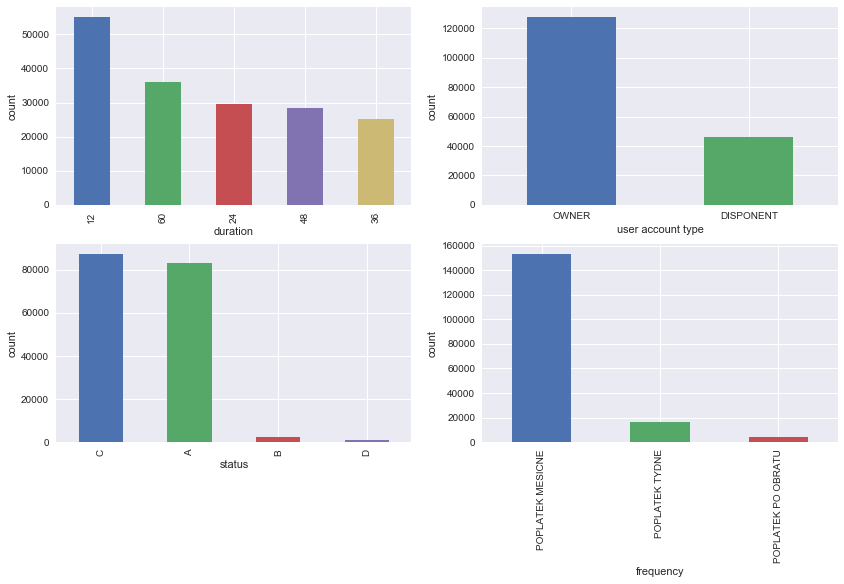

In [37]:
plt.figure(figsize = (14, 8))
plt.subplot(2, 2, 1)
data_cat.duration.value_counts().plot.bar()
plt.xlabel('duration')
plt.ylabel('count')

plt.subplot(2, 2, 2)
data_cat.type.value_counts().plot.bar()
plt.xlabel('user account type')
plt.ylabel('count')
plt.xticks(rotation = 0)

plt.subplot(2, 2, 3)
data_cat.status.value_counts().plot.bar()
plt.xlabel('status')
plt.ylabel('count')

plt.subplot(2, 2, 4)
data_cat.frequency.value_counts().plot.bar()
plt.xlabel('frequency')
plt.ylabel('count')

plt.show()

In [38]:
# check classes in categorical columns
def check_value_counts(x):
    return len(x.value_counts())

In [39]:
pd.DataFrame(data_cat.apply(lambda x: check_value_counts(x))).T

,account_id,loan_id,duration,status,order_id,bank_to,account_to,trans_id,district code,district name,region,card_id,issued,frequency,date,disp_id,client_id,type,birth_number
0,170,170,5,4,354,13,351,47127,60,60,8,170,160,3,162,206,206,2,205


In [40]:
data_cat_dum = pd.get_dummies(data_cat[['duration', 'status', 'bank_to', 'region','frequency','type']])

In [41]:
data_num.var() # to check variance

payments                                            5.170595e+06
amount                                              1.667617e+08
balance                                             5.923564e+08
no. of inhabitants                                  1.087212e+11
no. of municipalities with inhabitants < 499        9.304852e+02
no. of municipalities with inhabitants 500-1999     2.616588e+02
no. of municipalities with inhabitants 2000-9999    1.771684e+01
no. of municipalities with inhabitants >10000       1.316124e+00
no. of cities                                       8.735643e+00
ratio of urban inhabitants                          4.137929e+02
average salary                                      1.593380e+06
unemploymant rate 95                                3.592341e+00
unemploymant rate 96                                4.768352e+00
no. of enterpreneurs per 1000 inhabitants           4.749725e+02
no. of commited crimes 95                           6.111504e+08
no. of commited crimes 96

In [42]:
# let's remove variance from columns
scaler = StandardScaler()

In [43]:
data_num_sca = scaler.fit_transform(data_num)

C:\Users\nick2\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nick2\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [44]:
data_num_sca = pd.DataFrame(data_num_sca, index = data_num.index, columns = data_num.columns)

In [45]:
data_new = pd.concat([data_cat_dum, data_num_sca], axis = 1) # combining numerical and object dataframes back

In [46]:
data_new.shape

(174249, 51)

In [47]:
pd.DataFrame((np.random.random(len(data)) < .05).astype(int))[0].value_counts()

0    165508
1      8741
Name: 0, dtype: int64

In [48]:
# to reduce the features let's apply PCA

In [49]:
pca = PCA()
pca.fit(data_new)
features = range(pca.n_components_)

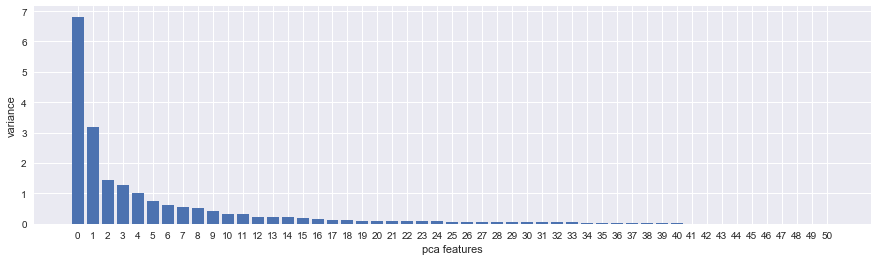

In [50]:
plt.figure(figsize = (15, 4))
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('pca features')
plt.show()

In [51]:
# from above bar plt showing variance, choosing 2 features 
pca = PCA(n_components = 2).fit(data_new) # fitting pca on dataframe 

In [52]:
data_new_pca = pca.transform(data_new)  # transforming dataframe to have only 2 features

In [53]:
data_new_pca

array([[ 2.82307941,  0.32841694],
       [ 2.78196777,  0.43693971],
       [ 2.79474751,  0.38081481],
       ...,
       [-1.33829255,  2.3613563 ],
       [-1.38803451,  2.4894892 ],
       [-1.37623734,  2.42037238]])

In [54]:
# our aim is to find a pattern in data points, so we can mark abnormal behaviour flag,
# let's use kmeans for getting the cluters and finding a pattern

In [55]:
kmeans = KMeans(n_clusters = 10) # picking 10 clusters after some thought

In [56]:
kmeans.fit(data_new_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [57]:
labels = kmeans.predict(data_new_pca)

In [58]:
print('labels are: ', np.unique(labels))

labels are:  [0 1 2 3 4 5 6 7 8 9]


In [59]:
# looking at the number of data points under each label/class
clusters_numbers = pd.DataFrame(pd.DataFrame(labels)[0].value_counts())
clusters_numbers.T

,9,5,1,2,7,4,3,0,8,6
0,51763,29611,17456,17343,14406,12549,12461,11471,3725,3464


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


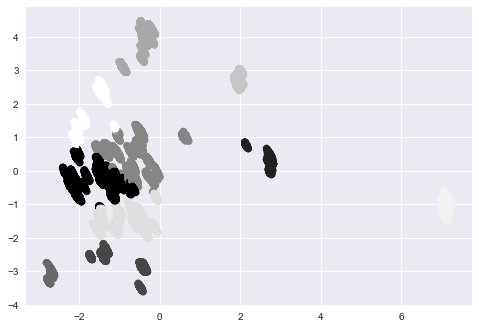

In [60]:
# plotting these clusters
plt.scatter(x =(data_new_pca)[:,0], y = (data_new_pca)[:,1], marker = 'o', c = labels)
plt.legend()
plt.show()

In [61]:
to_plot = pd.concat([pd.DataFrame(data_new_pca, columns= ['x', 'y']), pd.DataFrame(labels, columns= ['label'])], axis = 1)

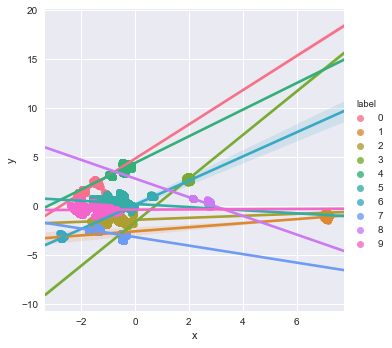

In [62]:
sns.lmplot(data = to_plot, x = 'x', y = 'y', hue = 'label' , legend = True)
plt.show()

In [63]:
 # cluster with 3725 data points is showing most steep downward line, let's pick these people for suspicious activity

In [64]:
choice3725, = clusters_numbers.index[clusters_numbers[0] == 3725]
print('cluster with most steep downward line is: ', choice3725)

cluster with most steep downward line is:  8


In [65]:
sb = pd.DataFrame(labels, columns= ['label'])

In [66]:
sb['flag'] = 0

In [67]:
sb.flag[sb.label == choice3725] = 1

In [68]:
sb.flag.value_counts()

0    170524
1      3725
Name: flag, dtype: int64

In [69]:
## Classification is performed below

In [70]:
data_new_sb = pd.concat([data_new, sb.flag], axis= 1) # non pca dataframe
data_new_pca_sb = pd.concat([pd.DataFrame(data_new_pca), sb.flag], axis= 1) # pca dataframe 

In [119]:
# the xgboost model generates error: 'ValueError: feature_names may not contain [, ] or <'
# to remove it, we'll rename the columns

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data_new_sb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data_new_sb.columns.values]
data_new_pca_sb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data_new_pca_sb.columns.values]

In [71]:
X = data_new_sb.drop('flag', axis = 1)
y = data_new_sb.flag

X_pca = data_new_pca_sb.drop('flag', axis = 1)
y_pca = data_new_pca_sb.flag

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size = 0.2, random_state = 1)

In [74]:
# using model_fit for the regular dataset with all columns of data

In [75]:
def model_clf(x): # models for non pca dataframe
    model = x
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_clf.cm = confusion_matrix(y_test, y_pred)
    model_clf.modl = str(x).split("(")[0]
    model_clf.accuracy = accuracy_score(y_test, y_pred)
    
def model_clf_pca(x):  # models for pca dataframe
    model = x
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_clf_pca.cm = confusion_matrix(y_test, y_pred)
    model_clf_pca.modl = str(x).split("(")[0]
    model_clf_pca.accuracy = accuracy_score(y_test, y_pred)

In [76]:
models_list = [LogisticRegression(random_state = 1234),
             
               KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2),
             
               SVC(kernel = 'rbf', random_state = 1234),
             
               GaussianNB(),
             
               DecisionTreeClassifier(criterion = 'entropy', random_state = 1234),
             
               RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 1234),
             
               XGBClassifier(base_score = 0.5, colsample_bylevel = 1, colsample_bytree = 1,
                                   gamma = 0, learning_rate = 0.1, max_delta_step = 0, max_depth = 1,
                                   min_child_weight = 1, missing = None, n_estimators = 700, nthread = -1,
                                   objective = 'binary:logistic', reg_alpha = 0, reg_lambda = 1,
                                   scale_pos_weight = 1, seed = 1234, silent = True, subsample = 1),
             
               GradientBoostingClassifier(random_state = 1234)]

In [77]:
start_time = time.clock()

name = []
accuracy = []
conf = []
for mdl in models_list:
    model_clf(mdl)
    name.append(model_clf.modl)
    accuracy.append(model_clf.accuracy)
    conf.append(model_clf.cm)
    
print(time.clock() - start_time, "seconds")

print("non pca model accuracies")

df_ac = pd.DataFrame({'Model Name': name, 
              'Accuracy' : accuracy, 
              'Confusion Matrix' : conf}).set_index('Model Name')

df_ac

27.764652899999998 seconds
non pca model accuracies


,Accuracy,Confusion Matrix
Model Name,,
LogisticRegression,1.0,"[[34098, 0], [0, 752]]"
KNeighborsClassifier,1.0,"[[34098, 0], [0, 752]]"
SVC,1.0,"[[34098, 0], [0, 752]]"
SVC,1.0,"[[34098, 0], [0, 752]]"
GaussianNB,1.0,"[[34098, 0], [0, 752]]"
DecisionTreeClassifier,1.0,"[[34098, 0], [0, 752]]"
RandomForestClassifier,1.0,"[[34098, 0], [0, 752]]"
XGBClassifier,1.0,"[[34098, 0], [0, 752]]"
GradientBoostingClassifier,1.0,"[[34098, 0], [0, 752]]"


In [78]:
start_time = time.clock()

name = []
accuracy = []
conf = []
for mdl in models_list:
    model_clf_pca(mdl)
    name.append(model_clf_pca.modl)
    accuracy.append(model_clf_pca.accuracy)
    conf.append(model_clf_pca.cm)
    
print(time.clock() - start_time, "seconds")
print("pca model accuracies")

df_ac = pd.DataFrame({'Model Name': name, 
              'Accuracy' : accuracy, 
              'Confusion Matrix' : conf}).set_index('Model Name')

df_ac

27.8509669 seconds
pca model accuracies


,Accuracy,Confusion Matrix
Model Name,,
LogisticRegression,1.0,"[[34098, 0], [0, 752]]"
KNeighborsClassifier,1.0,"[[34098, 0], [0, 752]]"
SVC,1.0,"[[34098, 0], [0, 752]]"
SVC,1.0,"[[34098, 0], [0, 752]]"
GaussianNB,1.0,"[[34098, 0], [0, 752]]"
DecisionTreeClassifier,1.0,"[[34098, 0], [0, 752]]"
RandomForestClassifier,1.0,"[[34098, 0], [0, 752]]"
XGBClassifier,1.0,"[[34098, 0], [0, 752]]"
GradientBoostingClassifier,1.0,"[[34098, 0], [0, 752]]"


In [79]:
# let's look at the important columns/features in the model affecting our results with XgBoost model

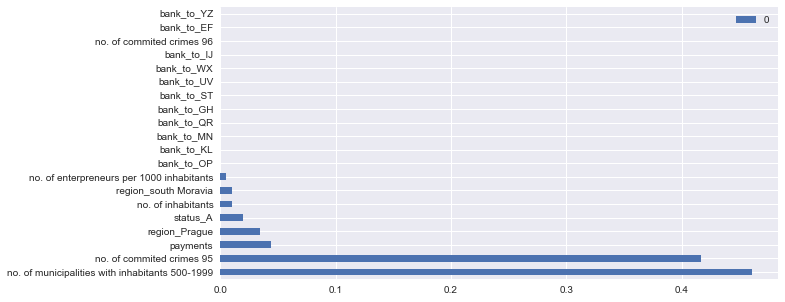

In [80]:
m = XGBClassifier(base_score = 0.5, colsample_bylevel = 1, colsample_bytree = 1,
                                   gamma = 0, learning_rate = 0.1, max_delta_step = 0, max_depth = 1,
                                   min_child_weight = 1, missing = None, n_estimators = 700, nthread = -1,
                                   objective = 'binary:logistic', reg_alpha = 0, reg_lambda = 1,
                                   scale_pos_weight = 1, seed = 1234, silent = True, subsample = 1).fit(X_train, y_train)
x = pd.DataFrame(m.feature_importances_, X_train.columns)
pd.DataFrame(x[0].sort_values(ascending = False)[0:20]).iloc[:,:1].plot.barh(figsize=(10,5))
plt.show()

In [81]:
# The accuracy scores produced by the models are near perfect. We will test to see if the imbalance in the prediction feature 
# is affecting the results by implementing the ROC curve and finding AUC. The imbalance is due to our prediction class being
# very small as our suspicious poplulation is mimicking the suspicious population in reality.

In [82]:
# Implementing the ROC curve on the logistic regression.  
prob_lr = LogisticRegression().fit(X_train_pca, y_train_pca).predict_proba(X_test_pca)

In [83]:
prob_lr = [p[1] for p in prob_lr]

#Verifying the last five scores in prob_lr
prob_lr[:5]

In [85]:
print("AUC score is: ", roc_auc_score(y_test, prob_lr)) # AUC score

AUC score is:  0.7901686378311326


In [ ]:
# The ROC_AUC is giving us less accuracy.  We can assume that the model was overfit and that the 
# imbalance is impacting the results

In [86]:
# plotting the ROC and AUC score
fpr, tpr, threshold = roc_curve(y_test, prob_lr)
print('fpr: ', fpr, '\ntpr: ', tpr, '\nthreshold: ', threshold)

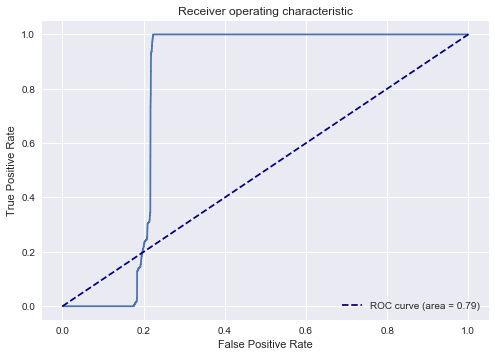

In [87]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--', label = 'ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()

In [88]:
data_new_pca_sb.flag.value_counts() # this is the imbalance of our classes

0    170524
1      3725
Name: flag, dtype: int64

In [89]:
# We will now try upsampling our prediction feature so we can mitigate the imbalance.

In [120]:
majority = data_new_sb[data_new_sb.flag == 0]
minority = data_new_sb[data_new_sb.flag == 1]

majority_pca = data_new_pca_sb[data_new_pca_sb.flag == 0]
minority_pca = data_new_pca_sb[data_new_pca_sb.flag == 1]

In [121]:
minority_upsampled = resample(minority, replace = True, n_samples = max(data_new_sb.flag.value_counts()), random_state = 1234)
minority_upsampled_pca = resample(minority_pca, replace = True, n_samples = max(data_new_pca_sb.flag.value_counts()), random_state = 1234)

In [122]:
upsampled = pd.concat([majority, minority_upsampled])
upsampled_pca = pd.concat([majority_pca, minority_upsampled_pca])
# New data set for upsampled values
print(upsampled.flag.value_counts())
print(upsampled_pca.flag.value_counts())

1    170524
0    170524
Name: flag, dtype: int64
1    170524
0    170524
Name: flag, dtype: int64


In [123]:
X_b = upsampled.drop('flag', axis = 1)
y_b = upsampled.flag

X_b_pca = upsampled_pca.drop('flag', axis = 1)
y_b_pca = upsampled_pca.flag

In [124]:
upsampled.shape, upsampled_pca.shape

((341048, 52), (341048, 3))

In [125]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size = 0.2, random_state = 1234)
X_train_b_pca, X_test_b_pca, y_train_b_pca, y_test_b_pca = train_test_split(X_b_pca, y_b_pca, test_size = 0.2, random_state = 1234)

In [126]:
def model_clf(x): # models for non pca dataframe
    model = x
    model.fit(X_train_b, y_train_b)
    y_pred = model.predict(X_test_b)
    
    model_clf.cm = confusion_matrix(y_test_b, y_pred)
    model_clf.modl = str(x).split("(")[0]
    model_clf.accuracy = accuracy_score(y_test_b, y_pred)
    
def model_clf_pca(x):  # models for pca dataframe
    model = x
    model.fit(X_train_b_pca, y_train_b_pca)
    y_pred = model.predict(X_test_b_pca)
    
    model_clf_pca.cm = confusion_matrix(y_test_b_pca, y_pred)
    model_clf_pca.modl = str(x).split("(")[0]
    model_clf_pca.accuracy = accuracy_score(y_test_b_pca, y_pred)

In [127]:
start_time = time.clock()

name = []
accuracy = []
conf = []
for mdl in models_list:
    model_clf(mdl)
    name.append(model_clf.modl)
    accuracy.append(model_clf.accuracy)
    conf.append(model_clf.cm)
    
print(time.clock() - start_time, "seconds")

print("non pca model accuracies")

df_ac = pd.DataFrame({'Model Name': name, 
              'Accuracy' : accuracy, 
              'Confusion Matrix' : conf}).set_index('Model Name')

df_ac

146.9492462999999 seconds
non pca model accuracies


,Accuracy,Confusion Matrix
Model Name,,
LogisticRegression,1.0,"[[33979, 0], [0, 34231]]"
KNeighborsClassifier,1.0,"[[33979, 0], [0, 34231]]"
SVC,1.0,"[[33979, 0], [0, 34231]]"
GaussianNB,1.0,"[[33979, 0], [0, 34231]]"
DecisionTreeClassifier,1.0,"[[33979, 0], [0, 34231]]"
RandomForestClassifier,1.0,"[[33979, 0], [0, 34231]]"
XGBClassifier,1.0,"[[33979, 0], [0, 34231]]"
GradientBoostingClassifier,1.0,"[[33979, 0], [0, 34231]]"


In [128]:
start_time = time.clock()

name = []
accuracy = []
conf = []
for mdl in models_list:
    model_clf_pca(mdl)
    name.append(model_clf_pca.modl)
    accuracy.append(model_clf_pca.accuracy)
    conf.append(model_clf_pca.cm)
    
print(time.clock() - start_time, "seconds")
print("pca model accuracies")

df_ac = pd.DataFrame({'Model Name': name, 
              'Accuracy' : accuracy, 
              'Confusion Matrix' : conf}).set_index('Model Name')

df_ac

26.443392200000062 seconds
pca model accuracies


,Accuracy,Confusion Matrix
Model Name,,
LogisticRegression,0.912374,"[[28002, 5977], [0, 34231]]"
KNeighborsClassifier,1.000000,"[[33979, 0], [0, 34231]]"
SVC,1.000000,"[[33979, 0], [0, 34231]]"
GaussianNB,1.000000,"[[33979, 0], [0, 34231]]"
DecisionTreeClassifier,1.000000,"[[33979, 0], [0, 34231]]"
RandomForestClassifier,1.000000,"[[33979, 0], [0, 34231]]"
XGBClassifier,1.000000,"[[33979, 0], [0, 34231]]"
GradientBoostingClassifier,1.000000,"[[33979, 0], [0, 34231]]"


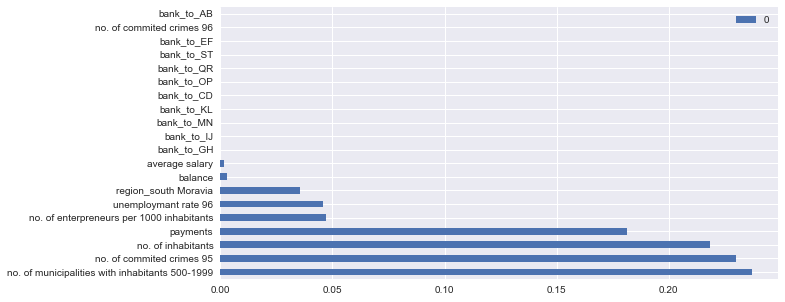

In [129]:
m = XGBClassifier(base_score = 0.5, colsample_bylevel = 1, colsample_bytree = 1,
                                   gamma = 0, learning_rate = 0.1, max_delta_step = 0, max_depth = 1,
                                   min_child_weight = 1, missing = None, n_estimators = 700, nthread = -1,
                                   objective = 'binary:logistic', reg_alpha = 0, reg_lambda = 1,
                                   scale_pos_weight = 1, seed = 1234, silent = True, subsample = 1).fit(X_train_b, y_train_b)
x = pd.DataFrame(m.feature_importances_, X_train_b.columns)
pd.DataFrame(x[0].sort_values(ascending = False)[0:20]).iloc[:,:1].plot.barh(figsize=(10,5))
plt.show()

In [ ]:
# still we are getting full accuracy with our models, it seems it should work better once we have the real flagged transactions